### **Paso 1:**
Primero conectamos nuestra cuenta de Drive con el fin de subir los  datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Paso 2:**
Cargamos el dataset que contiene las enfermedades con sus respectivos sintomas, son un total de 263 síntomas únicos, 201 enfermedades, 263 columnas y 50.250 filas.

In [2]:
import pandas as pd

file_path = '/content/drive/MyDrive/PI_2024-2/Datasets/medical_dataset.csv'

# Cargar el dataset
df = pd.read_csv(file_path)

print(df.head())

         diseases  sharp abdominal pain  vomiting  cough  headache  back pain  \
0  panic disorder                     0         0      0         0          0   
1  panic disorder                     0         0      0         0          0   
2  panic disorder                     0         0      0         0          0   
3  panic disorder                     0         0      0         0          0   
4  panic disorder                     0         0      0         0          0   

   nausea  fever  sharp chest pain  shortness of breath  ...  \
0       0      0                 0                    1  ...   
1       0      0                 0                    1  ...   
2       0      0                 0                    1  ...   
3       0      0                 0                    0  ...   
4       0      0                 0                    0  ...   

   knee stiffness or tightness  recent pregnancy  hip stiffness or tightness  \
0                            0                 0

### **Paso 3:**
Dividimos nuestro dataframe en 'X' y 'y', siendo 'X' las características y 'y' las etiquetas

In [3]:
# Separar características y etiquetas
X = df.drop(columns=['diseases'])
y = df['diseases']


# **Enfoque 1**
#### Haremos reducción de dimensionalidad aplicando SVD, usaremos ajuste de hiper parametros con Random Search y validación cruzada, entrenando 3 modelos diferentes:
- #### Regresión Logística Multinomial
- #### RandomForest
- #### XGBoost

### **Paso 1:**
Nuestros datos son dispersos, ya que tenemos 263 columnas que representan los síntomas, pero cada enfermedad solo tiene unos pocos síntomas asociados, lo que genera una gran cantidad de '0'. Para solucionar esto, aplicaremos reducción de dimensionalidad utilizando Descomposición en Valores Singulares (SVD), lo que nos permitirá reducir la complejidad del modelo y entrenarlo más rápidamente.

In [4]:
from sklearn.decomposition import TruncatedSVD

# Aplicar SVD para reducción dimensional
svd = TruncatedSVD(n_components=100, random_state=42)  # Reduce a 100 dimensiones
X_reduced = svd.fit_transform(X)

print("Dimensiones originales:", X.shape)
print("Dimensiones reducidas:", X_reduced.shape)

Dimensiones originales: (50250, 263)
Dimensiones reducidas: (50250, 100)


### **Paso 2:**
Dividir los datos en entrenamiento y prueba

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)

Tamaño de entrenamiento: (40200, 100)
Tamaño de prueba: (10050, 100)


### **Paso 3:**
Entramos nuestro modelo con los datos que acabamos de dividir, aplicando también ajuste de hiper parametros y validación cruzada

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import numpy as np
import time
import joblib
import os

# Rutas para guardar modelos
models_dir = "/content/drive/MyDrive/PI_2024-2/modelos_entrenados/"
os.makedirs(models_dir, exist_ok=True)

logreg_path = os.path.join(models_dir, "logreg_model.pkl")
rf_path = os.path.join(models_dir, "rf_model.pkl")
xgb_path = os.path.join(models_dir, "xgb_model.pkl")

# Codificar etiquetas de las enfermedades
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Verificar si los modelos ya están guardados
if os.path.exists(logreg_path) and os.path.exists(rf_path) and os.path.exists(xgb_path):
    # Cargar modelos guardados
    print("Cargando modelos entrenados desde Google Drive...")
    best_logreg_model = joblib.load(logreg_path)
    best_rf_model = joblib.load(rf_path)
    best_xgb_model = joblib.load(xgb_path)
else:
    # 1. Regresión Logística - Ajuste de hiperparámetros
    logreg_param_grid = {
        'C': np.logspace(-4, 4, 50),
        'solver': ['lbfgs', 'saga'],
        'multi_class': ['multinomial']
    }
    logreg_model = LogisticRegression(max_iter=1000, random_state=42)
    logreg_search = RandomizedSearchCV(
        logreg_model, logreg_param_grid, n_iter=5, cv=3, scoring='accuracy', random_state=42
    )

    start_time = time.time()
    logreg_search.fit(X_train, y_train)
    logreg_train_time = time.time() - start_time
    best_logreg_model = logreg_search.best_estimator_
    joblib.dump(best_logreg_model, logreg_path)  # Guardar modelo
    print("Modelo de Regresión Logística guardado.")

    # 2. Random Forest - Ajuste de hiperparámetros
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    }
    rf_model = RandomForestClassifier(random_state=42)
    rf_search = RandomizedSearchCV(
        rf_model, rf_param_grid, n_iter=5, cv=2, scoring='accuracy', random_state=42
    )

    start_time = time.time()
    rf_search.fit(X_train, y_train)
    rf_train_time = time.time() - start_time
    best_rf_model = rf_search.best_estimator_
    joblib.dump(best_rf_model, rf_path)  # Guardar modelo
    print("Modelo de Random Forest guardado.")

    # 3. XGBoost - Ajuste de hiperparámetros
    xgb_param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 6, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 1, 5],
    }
    xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)
    xgb_search = RandomizedSearchCV(
        xgb_model, xgb_param_grid, n_iter=3, cv=2, scoring='accuracy', random_state=42
    )

    start_time = time.time()
    xgb_search.fit(X_train, y_train_encoded)
    xgb_train_time = time.time() - start_time
    best_xgb_model = xgb_search.best_estimator_
    joblib.dump(best_xgb_model, xgb_path)  # Guardar modelo
    print("Modelo de XGBoost guardado.")

# Predicciones con los modelos cargados o entrenados
logreg_y_pred = best_logreg_model.predict(X_test)
rf_y_pred = best_rf_model.predict(X_test)
xgb_y_pred = best_xgb_model.predict(X_test)

# Evaluación de los modelos
print("\nEvaluación de los modelos:")
logreg_accuracy = accuracy_score(y_test, logreg_y_pred)
rf_accuracy = accuracy_score(y_test, rf_y_pred)
xgb_accuracy = accuracy_score(y_test_encoded, xgb_y_pred)
print(f"\nRegresión Logística - Accuracy: {logreg_accuracy:.4f}")
print(f"\nRandom Forest - Accuracy: {rf_accuracy:.4f}")
print(f"\nXGBoost - Accuracy: {xgb_accuracy:.4f}")

# Regresión Logística
print(f"\nRegresión Logística - Accuracy: {logreg_accuracy:.4f}")
print("Mejores hiperparámetros:", best_logreg_model.get_params())
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, logreg_y_pred))

# Random Forest
print(f"\nRandom Forest - Accuracy: {rf_accuracy:.4f}")
print("Mejores hiperparámetros:", best_rf_model.get_params())
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, rf_y_pred))

# XGBoost
print(f"\nXGBoost - Accuracy: {xgb_accuracy:.4f}")
print("Mejores hiperparámetros:", best_xgb_model.get_params())
classes_in_test_and_pred = set(y_test_encoded) & set(xgb_y_pred)
print("\nClassification Report (XGBoost):")
print(classification_report(
    y_test_encoded, xgb_y_pred, labels=list(classes_in_test_and_pred),
    target_names=label_encoder.classes_[list(classes_in_test_and_pred)]
))


Cargando modelos entrenados desde Google Drive...

Evaluación de los modelos:

Regresión Logística - Accuracy: 0.8706

Random Forest - Accuracy: 0.8142

XGBoost - Accuracy: 0.8043

Regresión Logística - Accuracy: 0.8706
Mejores hiperparámetros: {'C': 494.1713361323828, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'multinomial', 'n_jobs': None, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Classification Report (Logistic Regression):
                                                 precision    recall  f1-score   support

                              actinic keratosis       0.90      0.74      0.81        50
                            acute bronchiolitis       0.94      0.92      0.93        50
                               acute bronchitis       0.84      0.52      0.64        50
                             acute bronchospasm       0.

# **Gráficas**
### **1. Comparación de Accuracy entre modelos**

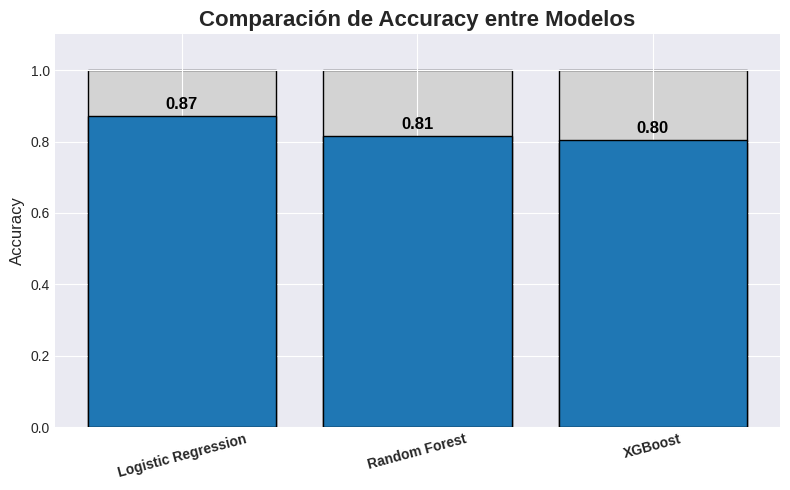

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Scores de los modelos
modelos = ['Logistic Regression', 'Random Forest', 'XGBoost']
scores = [logreg_accuracy, rf_accuracy, xgb_accuracy]

plt.style.use("seaborn-v0_8-darkgrid")

# Crear el gráfico de barras
fig, ax = plt.subplots(figsize=(8, 5))

# Añadir las barras
for i, score in enumerate(scores):
    ax.bar(modelos[i], 1, color='lightgray', edgecolor='black', zorder=0)  # Barra de fondo
    ax.bar(modelos[i], score, color='#1f77b4', edgecolor='black', zorder=1)  # Barra de score

# Configuración del gráfico
ax.set_ylim(0, 1.1)
ax.set_title('Comparación de Accuracy entre Modelos', fontsize=16, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_xticks(range(len(modelos)))
ax.set_xticklabels(modelos, rotation=15, fontsize=12, fontweight='bold')
ax.tick_params(axis='both', labelsize=10)

# Añadir valores encima de las barras
for i, score in enumerate(scores):
    ax.text(i, score + 0.02, f'{score:.2f}', ha='center', fontsize=12, fontweight='bold', color='black')

# Mejorar disposición y mostrar
plt.tight_layout()
plt.show()




### **2. Diagrama de Pareto**

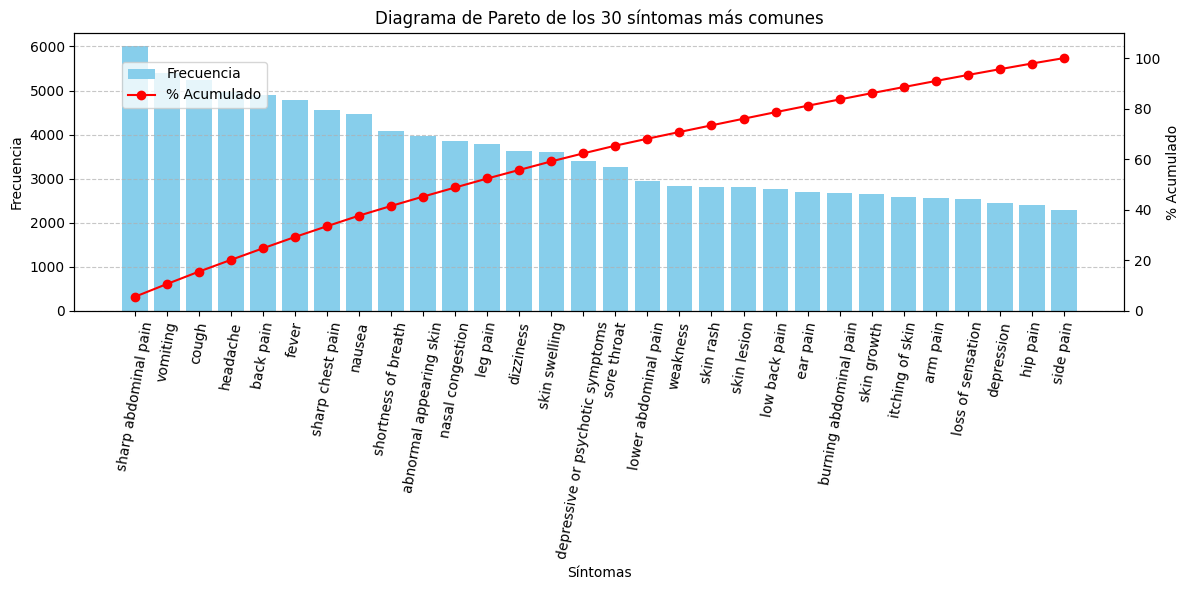

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular la frecuencia de los síntomas presentes
symptom_frequencies = X.sum().sort_values(ascending=False)

# Seleccionar los 30 síntomas más comunes
top_symptoms = symptom_frequencies.head(30)

# Calcular el porcentaje acumulado
cumulative_percentage = np.cumsum(top_symptoms) / top_symptoms.sum() * 100

# Crear el gráfico de barras y la línea de frecuencia acumulada
fig, ax = plt.subplots(figsize=(12, 6))

# Gráfico de barras
bars = ax.bar(top_symptoms.index, top_symptoms.values, color='skyblue', label='Frecuencia')

# Línea de porcentaje acumulado
ax2 = ax.twinx()
ax2.plot(top_symptoms.index, cumulative_percentage, color='red', marker='o', label='% Acumulado')

# Configuración del eje principal (barras)
ax.set_title('Diagrama de Pareto de los 30 síntomas más comunes')
ax.set_xlabel('Síntomas')
ax.set_ylabel('Frecuencia')
ax.tick_params(axis='x', rotation=80)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Configuración del eje secundario (línea de porcentaje)
ax2.set_ylabel('% Acumulado')
ax2.set_ylim(0, 110)
ax2.grid(visible=False)

# Leyendas y layout
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.tight_layout()
plt.show()





#### **3. Matrices de Confusión**

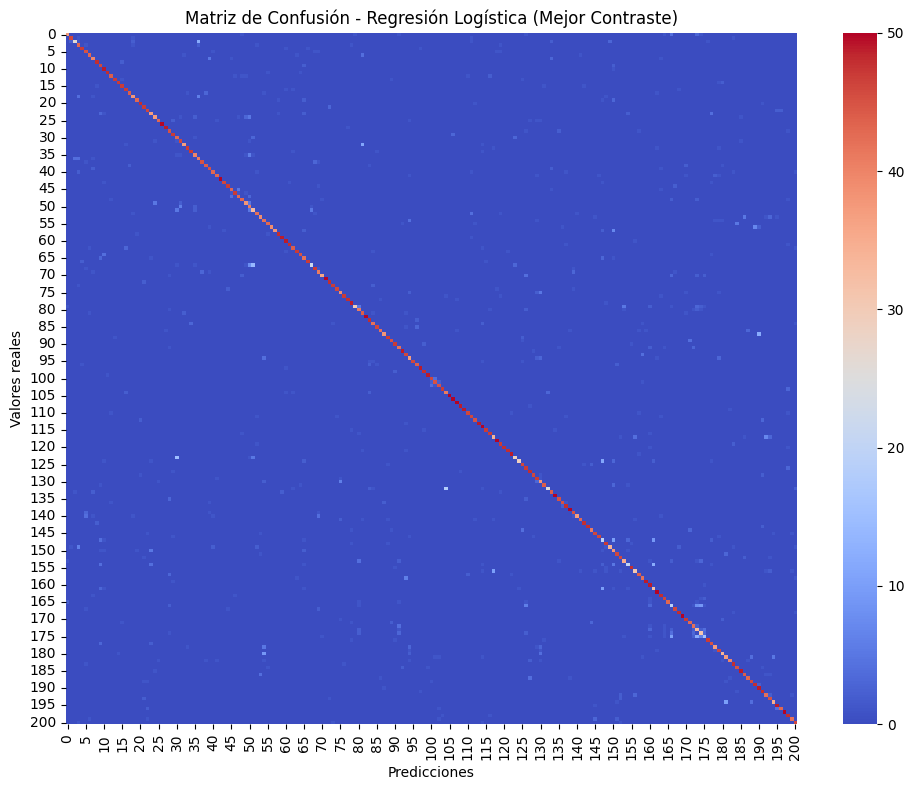

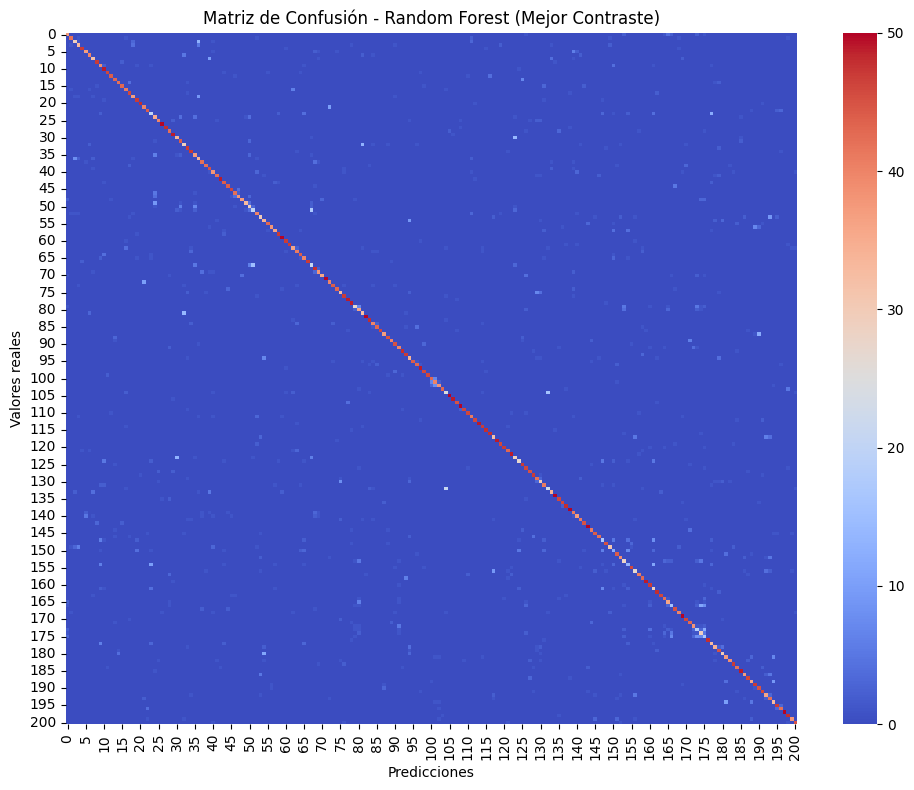

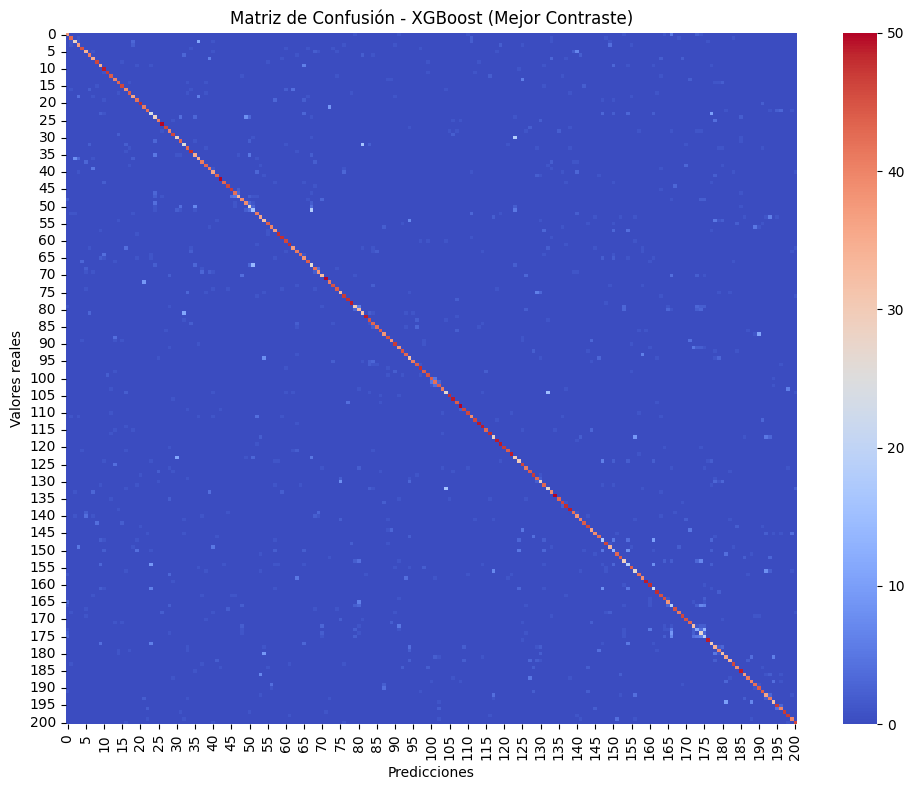

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Función para graficar la matriz de confusión
def plot_confusion_matrix_high_contrast(y_true, y_pred, title, cmap='coolwarm'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=False, cmap=cmap, cbar=True, vmin=0, vmax=cm.max())
    plt.title(title)
    plt.xlabel('Predicciones')
    plt.ylabel('Valores reales')
    plt.tight_layout()
    plt.show()

# Matriz de confusión con contraste mejorado para Regresión Logística
plot_confusion_matrix_high_contrast(y_test, logreg_y_pred, title="Matriz de Confusión - Regresión Logística")

# Matriz de confusión con contraste mejorado para Random Forest
plot_confusion_matrix_high_contrast(y_test, rf_y_pred, title="Matriz de Confusión - Random Forest")

# Matriz de confusión con contraste mejorado para XGBoost
plot_confusion_matrix_high_contrast(y_test_encoded, xgb_y_pred, title="Matriz de Confusión - XGBoost")





### **4. Análisis dimensional con t-SNE**

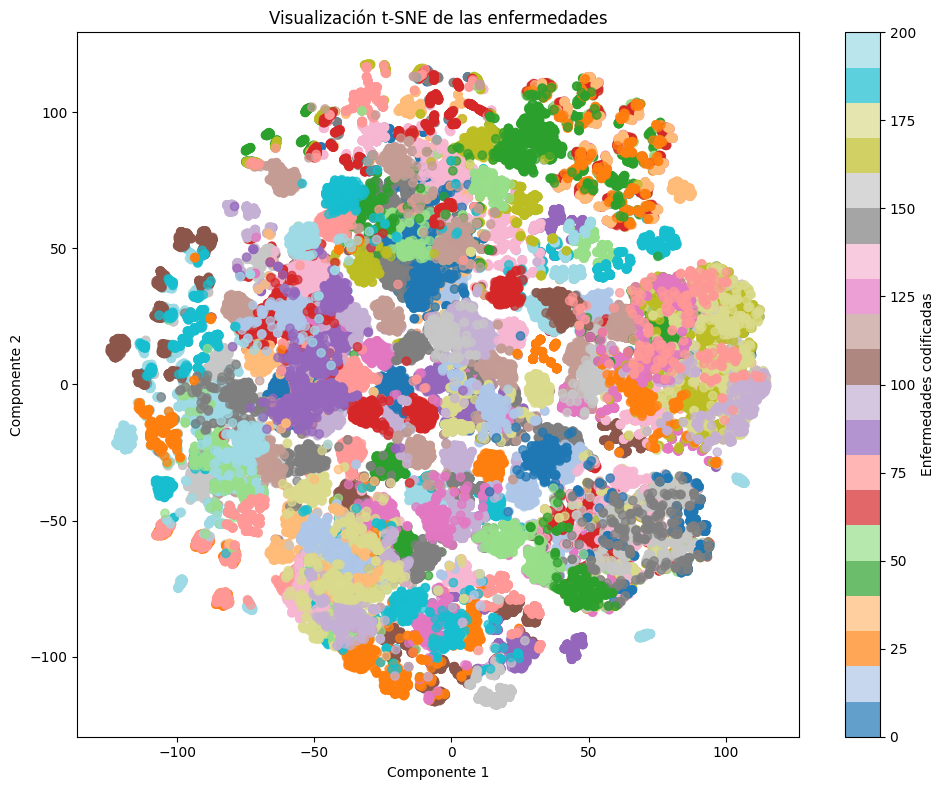

In [37]:
from sklearn.manifold import TSNE

# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

# Crear gráfico t-SNE
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label_encoder.transform(y), cmap='tab20', alpha=0.7)
plt.colorbar(scatter, label='Enfermedades codificadas')
plt.title('Visualización t-SNE de las enfermedades')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.tight_layout()
plt.show()

